# Business Proposal

Business problem: What are the best 5 zip codes to invest in?

Business - A real estate investment firm looking to acquire new property to invest in.

Focus - Investing in real estate for high growth zip codes.

Narrowing down zip codes - Look to see where everyone is trying to move to. Find the 25 highest historic ROI zipcodes from the past 10 years. Run a model for all 25 and then pick the best 5 zipcodes with the highest ROI.

Chosen State: Idaho
 - Based off of Census and other surveys deciding to go with Idaho.

Ways to narrow down zipcodes
 - looking at the historic 5 year ROI
 - Narrowing down to the best 25 zip codes
 - Doing a time series on all 25

# Loading all necessary packages and loading data file

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from urllib.request import urlopen
import json
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX




%matplotlib inline

from matplotlib import rcParams
plt.style.use('seaborn')
rcParams['figure.figsize']=(12,8)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)

In [2]:
data = pd.read_csv("Data/zillow_data.csv")

# EDA

In [3]:
data.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,341300.0,342600.0,344400.0,345700.0,346700.0,347800.0,349000.0,350400.0,352000.0,353900.0,356200.0,358800.0,361800.0,365700.0,370200.0,374700.0,378900.0,383500.0,388300.0,393300.0,398500.0,403800.0,409100.0,414600.0,420100.0,426200.0,432600.0,438600.0,444200.0,450000.0,455900.0,462100.0,468500.0,475300.0,482500.0,490200.0,498200.0,507200.0,516800.0,526300.0,535300.0,544500.0,553500.0,562400.0,571200.0,579800.0,588100.0,596300.0,604200.0,612200.0,620200.0,627700.0,634500.0,641000.0,647000.0,652700.0,658100.0,663300.0,668400.0,673400.0,678300.0,683200.0,688300.0,693300.0,698000.0,702400.0,706400.0,710200.0,714000.0,717800.0,721700.0,725700.0,729900.0,733400.0,735600.0,737200.0,739000.0,740900.0,742700.0,744400.0,746000.0,747200.0,748000.0,749000.0,750200.0,752300.0,755300.0,759200.0,764000.0,769600.0,775600.0,781900.0,787900.0,793200.0,798200.0,803100.0,807900.0,812900.0,818100.0,823100.0,828300.0,834100.0,839800.0,845600.0,851800.0,858000.0,864400.0,870700.0,876200.0,880700.0,884400.0,887600.0,890500.0,893300.0,895500.0,897300.0,899000.0,900400.0,902000.0,904400.0,907100.0,909700.0,911900.0,913000.0,913000.0,912000.0,909300.0,905300.0,901400.0,897900.0,895400.0,893600.0,891100.0,887000.0,881700.0,875900.0,870300.0,865100.0,859000.0,851500.0,843800.0,836400.0,830700.0,827300.0,824800.0,821600.0,818300.0,814600.0,809800.0,803600.0,795500.0,786900.0,780700.0,776900.0,774700.0,774200.0,774400.0,774600.0,775600.0,777800.0,775200.0,767900.0,764700.0,766100.0,764100.0,759700.0,754900.0,746200.0,737300.0,730800.0,729300.0,730200.0,730700.0,730000.0,730100.0,730100.0,731200.0,733900.0,735500.0,735400.0,734400.0,737500.0,737700.0,733700.0,734000.0,740300.0,744600.0,750500.0,760400.0,771800.0,780600.0,

In [4]:
data.tail()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
14718,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,94600.0,94300.0,94000.0,93700.0,93400.0,93200.0,93000.0,92900.0,92700.0,92600.0,92600.0,92600.0,92800.0,93100.0,93500.0,94000.0,94500.0,95100.0,95800.0,96500.0,97100.0,97800.0,98500.0,99200.0,100000.0,100800.0,101700.0,102600.0,103400.0,104200.0,104900.0,105600.0,106300.0,106800.0,107300.0,107800.0,108400.0,109000.0,109600.0,110200.0,110800.0,111400.0,112000.0,112600.0,113000.0,113500.0,113900.0,114300.0,114800.0,115400.0,116000.0,116700.0,117400.0,118100.0,118700.0,119500.0,120100.0,120600.0,121100.0,121700.0,122400.0,123300.0,124200.0,125300.0,126300.0,127400.0,128500.0,129600.0,130600.0,131400.0,132100.0,133000.0,133900.0,134900.0,136000.0,137200.0,138500.0,139700.0,140900.0,141900.0,143600.0,146300.0,149100.0,150900.0,151800.0,152000.0,151700.0,151700.0,152500.0,154200.0,156700.0,159800.0,163000.0,166000.0,168700.0,171400.0,174100.0,176800.0,179200.0,180800.0,181800.0,182400.0,182800.0,183200.0,183700.0,184300.0,185400.0,187300.0,190000.0,193400.0,197200.0,200600.0,203100.0,204400.0,205000.0,205300.0,205400.0,205500.0,205300.0,205100.0,204800.0,204800.0,204900.0,205200.0,205700.0,206200.0,206500.0,206500.0,206300.0,206100.0,205900.0,205600.0,205000.0,204100.0,202900.0,201600.0,200200.0,198900.0,197800.0,197100.0,196900.0,197300.0,197900.0,198100.0,197800.0,197200.0,196400.0,195600.0,194600.0,193400.0,192200.0,191300.0,190800.0,190700.0,190500.0,189800.0,188700.0,187500.0,186700.0,186600.0,187100.0,187300.0,187500.0,187700.0,188200.0,189000.0,190100.0,190200.0,188500.0,186200.0,184400.0,184400.0,185900.0,188000.0,188900.0,188900.0,187600.0,183700.0,177100.0,173200.0,173000.0,174700.0,176200.0,176300.0,174700.0,174000.0,174800.0,175800.0,175500.0,174600.0,174700.0,175200.0,175400.0,175200.0,175300.0,174500.0,173100.0,172700.0,1732

In [5]:
data.shape

(14723, 272)

## General info about the dataset

In [6]:
print('The data has {} number of entries. The number of unique RegionNames is {}.'.format(data.shape[0],data['RegionName'].nunique()))
print('So there seems to be no duplicate entries.')

The data has 14723 number of entries. The number of unique RegionNames is 14723.
So there seems to be no duplicate entries.


In [7]:
print('This dataset looks at {} different "states" (includes DC).'.format(data['State'].nunique()))

This dataset looks at 51 different "states" (includes DC).


In [8]:
print('This dataset looks at median prices of houses of a given zipcode from 1996-04 to 2018-04.')

This dataset looks at median prices of houses of a given zipcode from 1996-04 to 2018-04.


## Looking at missing values in the dataframe

In [9]:
#Seeing how many na values are in the dataset
print('There are {} Nan values in the dataset.'.format(data.isna().sum().sum()))

There are 157934 Nan values in the dataset.


In [10]:
#Checking to see what columns have na values.
column_names = data.columns
na_columns = []
for name in column_names:
    NumberOfNa = 0
    NumberOfNa = data[name].isna().sum()
    if NumberOfNa > 0:
        na_columns.append(name)
print('There are {} columns that have na values.'.format(len(na_columns)))
print('Only identifier column with na is "Metro", the others are missing values for dates')

There are 220 columns that have na values.
Only identifier column with na is "Metro", the others are missing values for dates


In [11]:
#Looking at the entries with Nan values for Metro
len(data.loc[lambda x: x.Metro.isna()])
data.loc[lambda x: x.Metro.isna()].head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
151,69340,27410,Greensboro,NC,NaN,Guilford,152,137100.0,136600.0,136000.0,135600.0,135300.0,135100.0,135200.0,135600.0,136100.0,136700.0,137500.0,138300.0,139000.0,139600.0,140000.0,140200.0,140400.0,140400.0,140400.0,140400.0,140400.0,140400.0,140600.0,141000.0,141600.0,142500.0,143700.0,145000.0,146400.0,147600.0,148800.0,149700.0,150500.0,150900.0,151300.0,151500.0,151600.0,151800.0,152100.0,152400.0,152900.0,153400.0,154000.0,154600.0,155300.0,156000.0,156700.0,157500.0,158400.0,159100.0,159900.0,160400.0,160900.0,161200.0,161400.0,161400.0,161300.0,161000.0,160800.0,160500.0,160300.0,160000.0,159800.0,159800.0,159900.0,160100.0,160400.0,160700.0,161200.0,161700.0,162200.0,162900.0,163700.0,164500.0,165200.0,165900.0,166400.0,166900.0,167400.0,167800.0,168300.0,168700.0,169000.0,169200.0,169500.0,169700.0,170000.0,170400.0,170700.0,171100.0,171400.0,171900.0,172400.0,173000.0,173600.0,174200.0,174800.0,175300.0,175900.0,176500.0,177200.0,178000.0,178600.0,179100.0,179500.0,179800.0,180100.0,180300.0,180600.0,180800.0,181100.0,181500.0,181700.0,182000.0,182400.0,182800.0,183200.0,183700.0,184300.0,185100.0,185900.0,186700.0,187400.0,188100.0,188600.0,189100.0,189700.0,190300.0,191100.0,192100.0,193000.0,193900.0,194700.0,195400.0,195800.0,196000.0,196000.0,196100.0,196200.0,196200.0,196200.0,196000.0,195600.0,195100.0,194400.0,193800.0,193100.0,192300.0,191700.0,191300.0,190900.0,190400.0,190000.0,189700.0,189400.0,189100.0,188700.0,188200.0,187700.0,187400.0,187200.0,187100.0,186700.0,186100.0,185600.0,184900.0,184800.0,184400.0,183400.0,182400.0,182300.0,182000.0,181600.0,181100.0,180900.0,180600.0,180400.0,180200.0,179800.0,179800.0,180200.0,180100.0,179500.0,179100.0,178900.0,178500.0,178000.0,177700.0,177400.0,177100.0,176800.0,176600.0,176700.0,177300.0,178200.0,179200.0,179300.0,17

In [12]:
# We can drop all the identifiers besides State, City and RegionName (Zipcode)
data_ZipcodeID = data.drop(['RegionID', 'Metro', 'CountyName', 'SizeRank'], axis=1)

In [13]:
# Creating a Dataframe with all entries that have any NA values
null_data = data_ZipcodeID[data_ZipcodeID.isnull().any(axis=1)]
print(len(null_data))
null_data.head()

1039


,RegionName,City,State,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
20,10011,New York,NY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3762100.0,3908800.0,4023200.0,4084800.0,4080800.0,4037400.0,4002300.0,4005300.0,4045100.0,4107700.0,4191200.0,4303900.0,4436300.0,4557300.0,4640100.0,4661400.0,4611100.0,4513000.0,4400600.0,4302700.0,4249100.0,4264800.0,4353300.0,4493200.0,4635000.0,4741700.0,4826000.0,4898000.0,4938400.0,4960300.0,5016400.0,5131200.0,5271900.0,5397300.0,5502400.0,5602000.0,5686800.0,5729600.0,5745800.0,5749900.0,5723500.0,5671500.0,5666900.0,5734700.0,5824300.0,5897600.0,5968500.0,6068200.0,6189600.0,6305600.0,6421200.0,6550900.0,6662700.0,6719200.0,6726100.0,6716600.0,6706900.0,6711300.0,6730200.0,6777200.0,6785500.0,6811100.0,6722700.0,6578200.0,6555400.0,6647400.0,6725000.0,6783400.0,6789200.0,6823100.0,6892500.0,6786000.0,6560600.0,6403400.0,6377300.0,6398000.0,6458000.0,6613600.0,6727900.0,6692400.0,6710100.0,6859800.0,6934100.0,6936700.0,7103800.0,7428300.0,7694600.0,7872000.0,7994800.0,8003300.0,7972900.0,7962600.0,7908600.0,7720400.0,7704700.0,7819500.0,7886000.0,7814000.0,7849900.0,7864300.0,7818000.0,7799300.0,7796000.0,7798300.0,7927500.0,8152300.0,8289100.0,8554800.0,8835500.0,9015500.0,9245400.0,9591500.0,9817900.0,9817300.0,9919200,10169600,10399000,10440400,10452500,10428700,10476500,10544400,10569300,10572500,10569500,10674900,10848100,11131200,11342700,11378800,11255300,11248600,11286600,11395300,11498100,11574100,11618900,11681200,11701600,11733900,11764800,11830000,11932900,12000400,1199880

A lot of the Nan values seem to be coming from possible newer properties that have been built.

In [14]:
print('The newest zipcode property, aka the last timestamp that has any nan value is {}.'.format(
    null_data.columns[null_data.isnull().any()][-1]))

The newest zipcode property, aka the last timestamp that has any nan value is 2014-06.


## Lets narrow the dataset to just Idaho before continuing on EDA

In [15]:
# Creating Idaho dataframe
Idaho = data_ZipcodeID[data_ZipcodeID['State'] == 'ID']
Idaho.head()

,RegionName,City,State,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
448,83301,Twin Falls,ID,94100.0,94100.0,94200.0,94200.0,94300.0,94400.0,94700.0,95200.0,96000.0,97000.0,98400.0,99900.0,101600.0,103200.0,104600.0,105700.0,106500.0,106900.0,106900.0,106500.0,105600.0,104600.0,103500.0,102600.0,101800.0,101400.0,101300.0,101300.0,101600.0,101900.0,102200.0,102500.0,102700.0,103000.0,103200.0,103200.0,103100.0,102900.0,102600.0,102400.0,102300.0,102400.0,102600.0,103000.0,103500.0,104000.0,104700.0,105400.0,106100.0,106900.0,107700.0,108500.0,109300.0,110200.0,111000.0,111700.0,112400.0,112900.0,113300.0,113400.0,113200.0,112600.0,111700.0,110700.0,109700.0,108800.0,108100.0,107800.0,107700.0,107700.0,107900.0,108200.0,108600.0,109000.0,109400.0,109900.0,110300.0,110500.0,110800.0,111000.0,111200.0,111400.0,111600.0,111900.0,112300.0,112700.0,113100.0,113400.0,113700.0,114000.0,114400.0,114700.0,115200.0,115800.0,116600.0,117400.0,118500.0,119700.0,121100.0,122400.0,123600.0,124800.0,125800.0,126700.0,127500.0,128100.0,128500.0,128700.0,128700.0,128700.0,128800.0,129200.0,129800.0,130500.0,131000.0,131500.0,131900.0,132400.0,133100.0,134100.0,135300.0,136500.0,137800.0,139200.0,140600.0,142100.0,143700.0,145300.0,146700.0,147900.0,148700.0,149400.0,150000.0,150300.0,150400.0,150500.0,150500.0,150400.0,150300.0,150400.0,150400.0,150200.0,149800.0,149400.0,148900.0,148000.0,146800.0,145700.0,144700.0,143800.0,143000.0,142300.0,141700.0,141200.0,140600.0,140300.0,140000.0,139400.0,138300.0,137200.0,135800.0,134500.0,133500.0,132600.0,132100.0,131900.0,132100.0,131500.0,130000.0,128900.0,128600.0,128000.0,126800.0,125400.0,124100.0,122700.0,121000.0,119400.0,118000.0,116800.0,116100.0,116100.0,116400.0,116600.0,116700.0,116900.0,117000.0,116800.0,116900.0,117200.0,117300.0,117300.0,117600.0,118200.0,118900.0,119100.0,119300.0,119700.0,120200.0,120700.0,121300.0,122200.0,123200.0,124200.0,125100.0,

In [16]:
# Creating a Dataframe with all entries that have any NA values for Idaho
Idaho_null = Idaho[Idaho.isnull().any(axis=1)]
print('There are {} zip codes on record for Idaho.'.format(len(Idaho)))
print('There are {} zip codes that have missing entries'.format(len(Idaho_null)))
Idaho_null.head()

There are 110 zip codes on record for Idaho.
There are 15 zip codes that have missing entries


,RegionName,City,State,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
7742,83333,Hailey,ID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,353400.0,366700.0,378400.0,388700.0,397100.0,402700.0,404800.0,403900.0,402200.0,401700.0,402600.0,404800.0,408100.0,411700.0,415500.0,418900.0,421100.0,421700.0,420500.0,417700.0,415500.0,414800.0,414500.0,414500.0,414900.0,415500.0,416500.0,418000.0,419200.0,419600.0,417800.0,413300.0,408300.0,403900.0,399200.0,394600.0,391200.0,388500.0,386400.0,384600.0,382700.0,380900.0,378400.0,374600.0,371200.0,368600.0,365300.0,361400.0,357900.0,354500.0,351300.0,348500.0,346500.0,343300.0,340700.0,341600.0,340200.0,334100.0,329700.0,328400.0,326200.0,322900.0,319400.0,316000.0,311800.0,306400.0,301300.0,297000.0,293000.0,290800.0,290500.0,290500.0,290500.0,291300.0,291800.0,291400.0,290500.0,289800.0,289600.0,288800.0,287700.0,287000.0,287100.0,287100.0,287000.0,287700.0,289300.0,290900.0,292100.0,293000.0,293400.0,293300.0,293600.0,294500.0,295500.0,296800.0,298900.0,300600.0,301500.0,302200.0,303300.0,304700.0,305900.0,306500.0,307900.0,309800.0,310900.0,311300.0,311600,311900,312900,314500,315500,317300,319300,320000,320100,320500,319700,317500,315300,312500,308000,303400,300800,300200,300500,300500,299900,300100,301800,303400,304000,303600,302900,302500,302500,302500,303400,304900,307400,310200,313000,315500,318000,319800,321700,324800,328400,331600,332800,335300,340900,345200
8131,83340,Ketchum,ID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [17]:
print('The newest Idaho zipcode property, aka the last timestamp that has any nan value is {}.'.format(
    Idaho_null.columns[Idaho_null.isnull().any()][-1]))

The newest Idaho zipcode property, aka the last timestamp that has any nan value is 2011-12.


In [18]:
#Dropping any zipcodes that do not have 10 years worth of data
Idaho = Idaho.drop(Idaho[Idaho['2008-04'].isnull()].index)

#Dropping columns for any previous data older than 10 years.
Idaho.dropna(axis=1, how='any', inplace=True)

print('2 of the Idaho zipcodes did not meet the 10 years worth of data requirement.')
print('The new number of zipcodes of the dataframe is {}.'.format(len(Idaho)))
print('The Idaho dataset now has no nan values and spans from {} to {}'.format(Idaho.columns[3],Idaho.columns[-1]))

2 of the Idaho zipcodes did not meet the 10 years worth of data requirement.
The new number of zipcodes of the dataframe is 108.
The Idaho dataset now has no nan values and spans from 2006-01 to 2018-04


In [19]:
Idaho.head()

,RegionName,City,State,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
448,83301,Twin Falls,ID,132400.0,133100.0,134100.0,135300.0,136500.0,137800.0,139200.0,140600.0,142100.0,143700.0,145300.0,146700.0,147900.0,148700.0,149400.0,150000.0,150300.0,150400.0,150500.0,150500.0,150400.0,150300.0,150400.0,150400.0,150200.0,149800.0,149400.0,148900.0,148000.0,146800.0,145700.0,144700.0,143800.0,143000.0,142300.0,141700.0,141200.0,140600.0,140300.0,140000.0,139400.0,138300.0,137200.0,135800.0,134500.0,133500.0,132600.0,132100.0,131900.0,132100.0,131500.0,130000.0,128900.0,128600.0,128000.0,126800.0,125400.0,124100.0,122700.0,121000.0,119400.0,118000.0,116800.0,116100.0,116100.0,116400.0,116600.0,116700.0,116900.0,117000.0,116800.0,116900.0,117200.0,117300.0,117300.0,117600.0,118200.0,118900.0,119100.0,119300.0,119700.0,120200.0,120700.0,121300.0,122200.0,123200.0,124200.0,125100.0,126100.0,126700.0,128600.0,132900.0,137400.0,140400.0,142500.0,143700.0,144600.0,145300.0,145800.0,146400.0,147200.0,148200.0,148800,148600,148200,147800,147200,146500,145300,144800,146100,148100,149400,150400,151100,151100,151300,151800,152200,153000,154400,155700,156600,157400,158100,158800,159500,159500,158900,159000,160100,161300,162400,163500,164300,164400,164200,164100,164300,164700,164900,166400,170000,173800,176400,177800,178800,179800
596,83709,Boise,ID,199200.0,203300.0,207200.0,211500.0,215900.0,220000.0,223300.0,225300.0,225800.0,225000.0,223700.0,222500.0,221700.0,220600.0,219500.0,218800.0,218400.0,217900.0,217600.0,217500.0,217400.0,217400.0,217300.0,217300.0,217600.0,217600.0,217100.0,216500.0,215600.0,213800.0,211500.0,208800.0,206200.0,203700.0,201300.0,199100.0,197400.0,195500.0,193300.0,191000.0,188700.0,186100.0,183900.0,182200.0,180700.0,179300.0,178100.0,176800.0,173900.0,173200.0,173800.0,172700.0,170600.0,170200.0,169200.0,167700.0,165900.0,164300.0,163200.0,162300.0,161700.0,159800.0,157300.0,155400.0,153500.0,151300.0,150100.0,149300.0,148600.0,148500.0,148200.0,147000.0,146100.0,146400.0,147000.0,147800.0,148900.0,149700.0,150100.0,150600.0,151600.0,152900.0,154300.0,156100.0,158200.0,159400.0,160200.0,161900.0,164700.0,168200.0,171800.0,174700.0,176900.0,178400.0,180400.0,183100.0,185000.0,186000.0,187300.0,188600.0,189300.0,189500.0,189300,188600,187900,187600,187700,188700,190600,192200,193100,194200,196000,198000,199500,200300,200700,201700,203300,204800,206200,207900,209300,210800,212000,213300,214300,214900,216200,218100,219900,221400,223400,225600,228500,231900,235200,237000,242200,251800,261200,263500,261100,257000,255200,255100,256200,256600
1178,83686,Nampa,ID,147100.0,148000.0,149400.0,151500.0,153800.0,156300.0,158900.0,161400.0,164100.0,166500.0,168800.0,170900.0,172600.0,173800.0,174900.0,176200.0,177600.0,178500.0,178900.0,179200.0,179800.0,180600.0,181400.0,182300.0,183000.0,182900.0,182400.0,181800.

## Looking at last 12 months price distribution for Idaho

In [20]:
Idaho['Last12MonthAvg'] = Idaho.iloc[:,-12:].mean(axis=1)

In [21]:
Idaho['Last12MonthAvg'].describe()

count    1.080000e+02
mean     2.301512e+05
std      1.418955e+05
min      8.119167e+04
25%      1.595229e+05
50%      2.010542e+05
75%      2.482292e+05
max      1.234542e+06
Name: Last12MonthAvg, dtype: float64

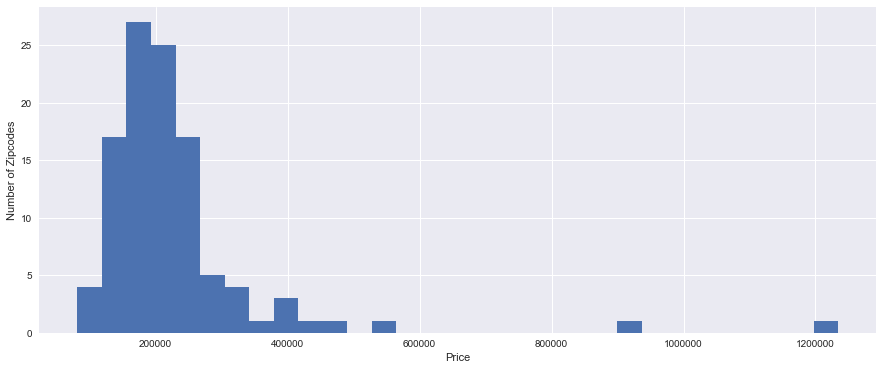

In [22]:
plt.figure(figsize=(15,6))
plt.hist(Idaho['Last12MonthAvg'], bins='auto');
plt.ylabel('Number of Zipcodes');
plt.xlabel('Price');

## Calculate ROI (1yr, 5yr, 10yr) and CV

In [23]:
#Calculate ROI for 1 year, 5 year, 10 year
Idaho['1yr_ROI'] = (Idaho['2018-04'] / Idaho['2017-04']) - 1
Idaho['5yr_ROI'] = (Idaho['2018-04'] / Idaho['2013-04']) - 1
Idaho['10yr_ROI'] = (Idaho['2018-04'] / Idaho['2008-04']) - 1

In [24]:
#Calculate CV
Idaho['std'] = Idaho.loc[:,'2006-01':'2018-04'].std(axis=1)
Idaho['mean'] = Idaho.loc[:,'2006-01':'2018-04'].mean(axis=1)
Idaho['CV'] = Idaho['std'] / Idaho['mean']

In [25]:
Idaho

,RegionName,City,State,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,Last12MonthAvg,1yr_ROI,5yr_ROI,10yr_ROI,std,mean,CV
448,83301,Twin Falls,ID,132400.0,133100.0,134100.0,135300.0,136500.0,137800.0,139200.0,140600.0,142100.0,143700.0,145300.0,146700.0,147900.0,148700.0,149400.0,150000.0,150300.0,150400.0,150500.0,150500.0,150400.0,150300.0,150400.0,150400.0,150200.0,149800.0,149400.0,148900.0,148000.0,146800.0,145700.0,144700.0,143800.0,143000.0,142300.0,141700.0,141200.0,140600.0,140300.0,140000.0,139400.0,138300.0,137200.0,135800.0,134500.0,133500.0,132600.0,132100.0,131900.0,132100.0,131500.0,130000.0,128900.0,128600.0,128000.0,126800.0,125400.0,124100.0,122700.0,121000.0,119400.0,118000.0,116800.0,116100.0,116100.0,116400.0,116600.0,116700.0,116900.0,117000.0,116800.0,116900.0,117200.0,117300.0,117300.0,117600.0,118200.0,118900.0,119100.0,119300.0,119700.0,120200.0,120700.0,121300.0,122200.0,123200.0,124200.0,125100.0,126100.0,126700.0,128600.0,132900.0,137400.0,140400.0,142500.0,143700.0,144600.0,145300.0,145800.0,146400.0,147200.0,148200.0,148800,148600,148200,147800,147200,146500,145300,144800,146100,148100,149400,150400,151100,151100,151300,151800,152200,153000,154400,155700,156600,157400,158100,158800,159500,159500,158900,159000,160100,161300,162400,163500,164300,164400,164200,164100,164300,164700,164900,166400,170000,173800,176400,177800,178800,179800,1.704333e+05,0.093674,0.437250,0.207522,15843.932315,1.416122e+05,0.111883
596,83709,Boise,ID,199200.0,203300.0,207200.0,211500.0,215900.0,220000.0,223300.0,225300.0,225800.0,225000.0,223700.0,222500.0,221700.0,220600.0,219500.0,218800.0,218400.0,217900.0,217600.0,217500.0,217400.0,217400.0,217300.0,217300.0,217600.0,217600.0,217100.0,216500.0,215600.0,213800.0,211500.0,208800.0,206200.0,203700.0,201300.0,199100.0,197400.0,195500.0,193300.0,191000.0,188700.0,186100.0,183900.0,182200.0,180700.0,179300.0,178100.0,176800.0,173900.0,173200.0,173800.0,172700.0,170600.0,170200.0,169200.0,167700.0,165900.0,164300.0,163200.0,162300.0,161700.0,159800.0,157300.0,155400.0,153500.0,151300.0,150100.0,149300.0,148600.0,148500.0,148200.0,147000.0,146100.0,146400.0,147000.0,147800.0,148900.0,149700.0,150100.0,150600.0,151600.0,152900.0,154300.0,156100.0,158200.0,159400.0,160200.0,161900.0,164700.0,168200.0,171800.0,174700.0,176900.0,178400.0,180400.0,183100.0,185000.0,186000.0,187300.0,188600.0,189300.0,189500.0,189300,188600,187900,187600,187700,188700,190600,192200,193100,194200,196000,198000,199500,200300,200700,201700,203300,204800,206200,207900,209300,210800,212000,213300,214300,214900,216200,218100,219900,221400,223400,225600,228500,231900,235200,237000,242200,251800,261200,263500,261100,257000,255200,255100,256200,256600,2.526750e+05,0.106511,0.584929,0.185219,29942.939507,1.947209e+05,0.153774
1178,83686,Nampa,ID,147100.0,148000.0,149400.0,151500.0,153800.0,156

In [26]:
print('Choosing to use 5yr ROI for historic ROI metric.')
print('The least you should hold a Property or REIT is 5 years to see gains on income/appreciation.')
print('Was thinking of using ')

Choosing to use 5yr ROI for historic ROI metric.
The least you should hold a Property or REIT is 5 years to see gains on income/appreciation.
Was thinking of using 


## Narrowing zipcodes down to historic best 25 candidates

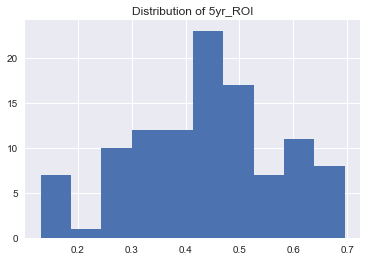

In [27]:
#Looking at distribution of 5yr_ROI
Idaho['5yr_ROI'].hist()
plt.title('Distribution of 5yr_ROI');

In [28]:
#Taking the top 25 zipcodes that have the best 5yr_ROI
Idaho_25 = Idaho.sort_values(by=['5yr_ROI'], ascending=False)[0:25]

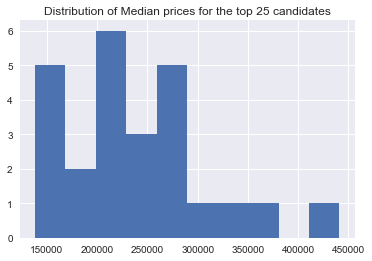

In [29]:
#Looking at the median price distribution of the top 25
Idaho_25['2018-04'].hist()
plt.title('Distribution of Median prices for the top 25 candidates');

## Turning the top 25 zip codes into long format

In [30]:
#This will take in the data(series) and turn it into a df(long format)
def LongFormat(data):
    
    #Turns series into df
    df = pd.DataFrame(data)
    
    #Drops the unwanted identity entries and calculations
    df = df.drop(labels=['RegionName','City','State','Last12MonthAvg',
                                 '1yr_ROI', '5yr_ROI', '10yr_ROI', 'std', 'mean', 'CV'],axis=0)
    
    #Turns the index into date time
    df.index = pd.to_datetime(df.index)
    df = df.asfreq('MS')
    
    #Labels the prices as value
    df.columns = ['value']
    
    return df

In [31]:
#This pulls each zipcode entry from the dataframe and appends the data to a list
Idaho_25_list = []
for i in range(len(Idaho_25)):
    Idaho_25_list.append(Idaho_25.iloc[i][:])

#Creating a dictionary with the zipcode as the key and the long format dataframe as the value
Idaho_25_dict = {}
for x in Idaho_25_list:
    Idaho_25_dict[str(x[0])] = LongFormat(x)

In [32]:
Idaho_25_dict.keys()

dict_keys(['83703', '83814', '83676', '83605', '83702', '83705', '83651', '83350', '83801', '83845', '83347', '83607', '83336', '83706', '83655', '83835', '83687', '83714', '83709', '83704', '83815', '83686', '83660', '83276', '83858'])

In [33]:
Idaho_25_dict['83703'].head()

,value
2006-01-01,182900
2006-02-01,186600
2006-03-01,190000
2006-04-01,193800
2006-05-01,197900


## Looking at the price plots (try zooming in and out)

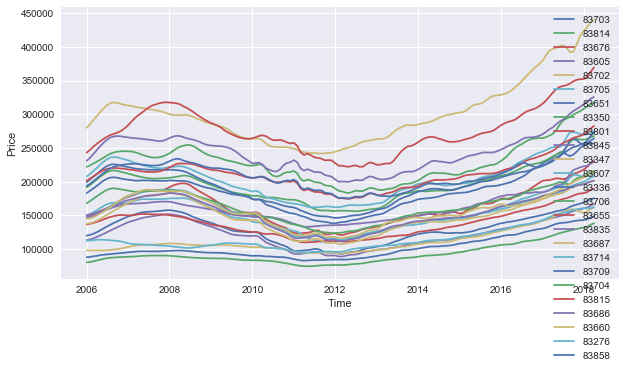

In [34]:
fig, ax = plt.subplots(figsize=(10,5))

for k,v in Idaho_25_dict.items():
        ax.plot(v, label=k)
        ax.set_ylabel('Price')
        ax.set_xlabel('Time')
        ax.legend()
        

## Seasonal Decompose

In [35]:
## Checking to see if there is any sort of seasonality to the zipcodes

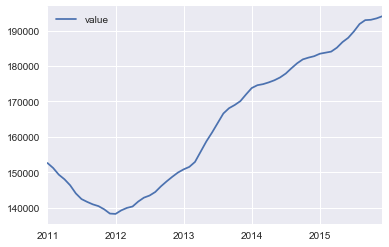

In [36]:
Idaho_25_dict['83703'][60:120].plot()

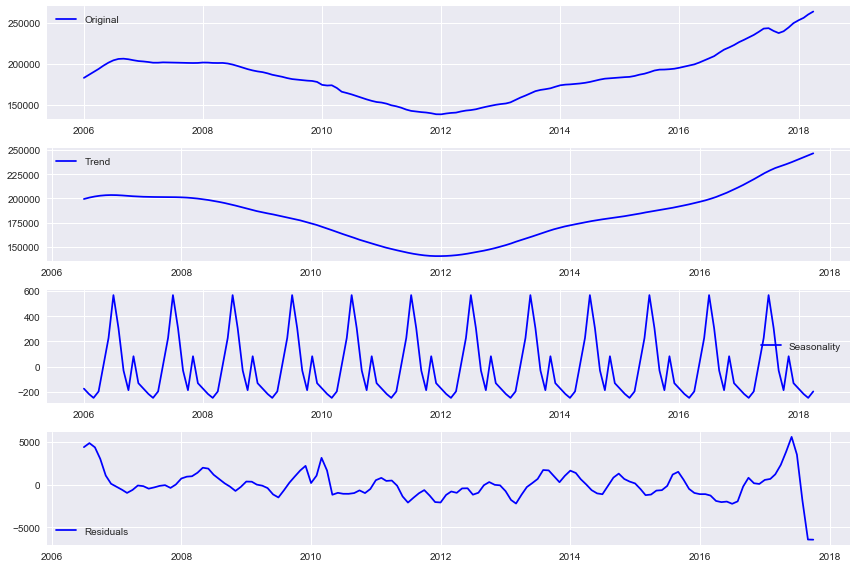

In [37]:
# Taking the decomposition of one zip code
decomposition = seasonal_decompose(Idaho_25_dict['83703'])

# Gathering and plotting the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(Idaho_25_dict['83703'], label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

In [38]:
# Look more into the seasonal plot and see how long a "season" is. Most likely 12 months.

## Maps (Uncomment to run)

In [39]:
#with urlopen('https://raw.githubusercontent.com/OpenDataDE/State-zip-code-GeoJSON/master/id_idaho_zip_codes_geo.min.json') as response:
#    Idaho_Map = json.load(response)

#Idaho_Map["features"][0]

In [40]:
#Don't run this will make the map but it will be too large of a size, deal with this later.

#fig = px.choropleth(Idaho, geojson=Idaho_Map, color="5yr_ROI",
#                    locations="RegionName", featureidkey="properties.ZCTA5CE10",
#                    projection="mercator", hover_data=['City']
#                   )
#fig.update_geos(fitbounds="locations", visible=True)
#fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
#fig.show()

# Modeling

## First going to make one model to see if we can get it to work

In [41]:
Idaho_25_dict['83703'].index

DatetimeIndex(['2006-01-01', '2006-02-01', '2006-03-01', '2006-04-01', '2006-05-01', '2006-06-01', '2006-07-01', '2006-08-01', '2006-09-01', '2006-10-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01'], dtype='datetime64[ns]', length=148, freq='MS')

Using pmd arima to gather the parameters that are best for modeling

In [42]:
# Train size is 10 years, test size is 28 months (2 years and 4 months)
train, test = train_test_split(Idaho_25_dict['83703'], train_size=120)

In [43]:
auto_model = pm.auto_arima(y=train, start_p=0, start_q=0, max_p=5, max_q=5,
                           start_P=0, start_Q=0, max_P=5, max_Q=5, m=12, trace=True)

display(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1905.296, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1909.042, Time=0.07 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1909.041, Time=0.10 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1907.291, Time=0.26 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1909.519, Time=0.03 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1910.586, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1907.080, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1907.076, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1908.770, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1907.158, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.642 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -951.648
Date:                Tue, 06 Apr 2021   AIC                           1905.296
Time:                        19:38:22   BIC                           1908.067
Sample:                             0   HQIC                          1906.421
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.921e+05   3.84e+04     15.417      0.000    5.17e+05    6.67e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):               180.10
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                            -0.18
Prob(H) (two-sided):                  0.68   Kurtosis:                         9.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

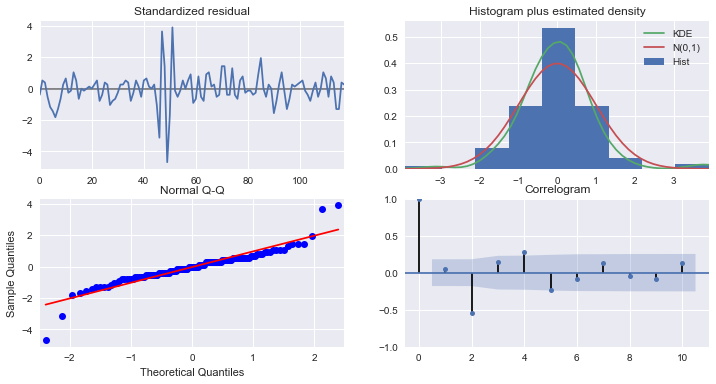

In [52]:
auto_model.plot_diagnostics(figsize=(12,6));

In [45]:
auto_model.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (0, 2, 0),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 0, 0, 12),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  120
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -944.006
Date:                Tue, 06 Apr 2021   AIC                           1890.011
Time:                        19:38:23   BIC                           1892.773
Sample:                    01-01-2006   HQIC                          1891.133
                         - 12-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.962e+05    3.9e+04     15.305      0.000     5.2e+05    6.73e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):               175.40
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                            -0.19
Prob(H) (two-sided):                  0.69   Kurtosis:                         8.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

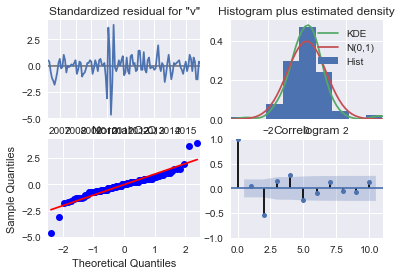

In [46]:
Test_model = SARIMAX(train['value'].astype('int'),
                    order=auto_model.order,
                    seasonal_order=auto_model.seasonal_order,
                    enforce_invertibility=False,
                    enforce_stationarity=False)
output = Test_model.fit()
display(output.summary());
output.plot_diagnostics(figsize=(12,8));

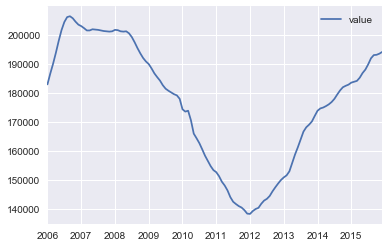

In [53]:
train.plot()

In [94]:
forecast = output.get_prediction(start='2016-01-01',end='2018-04-01',dynamic=False)
forecast_conf = forecast.conf_int()

In [95]:
forecast.predicted_mean

2016-01-01    194700.0
2016-02-01    195300.0
2016-03-01    195900.0
2016-04-01    196500.0
2016-05-01    197100.0
2016-06-01    197700.0
2016-07-01    198300.0
2016-08-01    198900.0
2016-09-01    199500.0
2016-10-01    200100.0
2016-11-01    200700.0
2016-12-01    201300.0
2017-01-01    201900.0
2017-02-01    202500.0
2017-03-01    203100.0
2017-04-01    203700.0
2017-05-01    204300.0
2017-06-01    204900.0
2017-07-01    205500.0
2017-08-01    206100.0
2017-09-01    206700.0
2017-10-01    207300.0
2017-11-01    207900.0
2017-12-01    208500.0
2018-01-01    209100.0
2018-02-01    209700.0
2018-03-01    210300.0
2018-04-01    210900.0
Freq: MS, Name: predicted_mean, dtype: float64

In [96]:
forecast_conf

,lower value,upper value
2016-01-01,193186.622957,196213.377043
2016-02-01,191915.986056,198684.013944
2016-03-01,190237.461607,201562.538393
2016-04-01,188210.892554,204789.107446
2016-05-01,185876.495462,208323.504538
2016-06-01,183263.303120,212136.696880
2016-07-01,180393.481341,216206.518659
2016-08-01,177284.652321,220515.347679
2016-09-01,173951.254995,225048.745005
2016-10-01,170405.398153,229794.601847


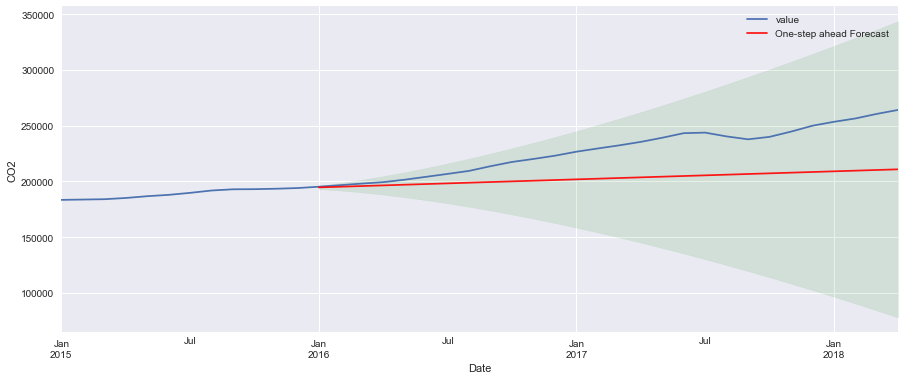

In [99]:
# Plot real vs predicted values along with confidence interval
rcParams['figure.figsize'] = 15,6

# Plot observed values
ax = Idaho_25_dict['83703']['2015':].plot()

# Plot predicted values
forecast.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', color='red', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(forecast_conf.index,
                forecast_conf.iloc[:, 0],
                forecast_conf.iloc[:, 1], color='g', alpha=0.1)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()
plt.show()

In [107]:
y_hat = forecast.predicted_mean
real_values = Idaho_25_dict['83703']['2016-01-01':]['value']

# Compute the mean square error
mse = ((real_values-y_hat)**2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 886545357.14


In [114]:
real_values-y_hat

2016-01-01      600
2016-02-01     1400
2016-03-01     2200
2016-04-01     2900
2016-05-01     4500
2016-06-01     6500
2016-07-01     8500
2016-08-01    10600
2016-09-01    14200
2016-10-01    17400
2016-11-01    19500
2016-12-01    21800
2017-01-01    24800
2017-02-01    27100
2017-03-01    29300
2017-04-01    31800
2017-05-01    34900
2017-06-01    38400
2017-07-01    38300
2017-08-01    34300
2017-09-01    31100
2017-10-01    32700
2017-11-01    36800
2017-12-01    41500
2018-01-01    44400
2018-02-01    46800
2018-03-01    50300
2018-04-01    53300
Freq: MS, dtype: object

## Stopped here

## Making a function to model all 25 zipcodes

Make sure to have a table that will store all aspects of the models.

In [ ]:
def autobot(data, dynamic=True):
    
    # Train size is 10 years, test size is 28 months (2 years and 4 months)
    train, test = train_test_split(data, train_size=120)
    
    # Using pm auto_arima to find the best parameters
    auto_model = pm.auto_arima(y=train, start_p=0, start_q=0, max_p=5, max_q=5,
                           start_P=0, start_Q=0, max_P=5, max_Q=5, m=12, trace=True)
    display(auto_model.summary())
    
    # Making the actual SARIMAX model with the best parameters
    Test_model = SARIMAX(train['value'].astype('int'),
                    order=auto_model.order,
                    seasonal_order=auto_model.seasonal_order,
                    enforce_invertibility=False,
                    enforce_stationarity=False)
    output = Test_model.fit()
    display(output.summary());
    output.plot_diagnostics(figsize=(12,8));
    
    # Getting Forecast data
    forecast = output.get_prediction(start='2016-01-01',end='2018-04-01',dynamic=dynamic)
    forecast_conf = forecast.conf_int()
    
    # Calculating MSE
    y_hat = forecast.predicted_mean
    real_values = Idaho_25_dict['83703']['2016-01-01':]['value']
    mse = ((real_values-y_hat)**2).mean()

## Scratch work

To do:
- look at trends
- maybe look in rolling mean
- zoom in annomalies?

In [47]:
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

In [48]:
Idaho_25.head()

,RegionName,City,State,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,Last12MonthAvg,1yr_ROI,5yr_ROI,10yr_ROI,std,mean,CV
5764,83703,Boise,ID,182900.0,186600.0,190000.0,193800.0,197900.0,201600.0,204400.0,206100.0,206400.0,205700.0,204500.0,203500.0,203000.0,202300.0,201500.0,201500.0,201900.0,201800.0,201700.0,201500.0,201300.0,201200.0,201100.0,201200.0,201700.0,201600.0,201200.0,201100.0,201200.0,200500.0,199200.0,197400.0,195400.0,193600.0,192000.0,190800.0,189900.0,188400.0,186700.0,185400.0,184200.0,182600.0,181400.0,180700.0,180100.0,179500.0,179100.0,177900.0,174300.0,173500.0,173800.0,170500.0,165900.0,164300.0,162600.0,160500.0,158300.0,156500.0,154700.0,153300.0,152600.0,151200.0,149300.0,148000.0,146300.0,144000.0,142400.0,141600.0,140900.0,140400.0,139500.0,138300.0,138200.0,139200.0,139900.0,140300.0,141700.0,142800.0,143400.0,144400.0,146000.0,147400.0,148700.0,149900.0,150800.0,151500.0,152900.0,155800.0,158700.0,161200.0,163900.0,166600.0,168100.0,169000.0,170100.0,172000.0,173800.0,174600.0,174900.0,175400.0,176000.0,176800.0,177900,179400,180800,181900,182400,182800,183500,183800,184100,185200,186800,188000,189800,191900,193000,193100,193500,194100,195300,196700,198100,199400,201600,204200,206800,209500,213700,217500,220200,223100,226700,229600,232400,235500,239200,243300,243800,240400,237800,240000,244700,250000,253500,256500,260600,264200,247833.333333,0.121868,0.695764,0.313774,29411.594733,186000.000000,0.158127
3199,83814,Coeur d'Alene,ID,221800.0,224200.0,226800.0,229500.0,232500.0,235700.0,238900.0,241600.0,243500.0,244500.0,245000.0,245200.0,245000.0,244600.0,243700.0,242100.0,240000.0,238400.0,236900.0,235900.0,235600.0,236100.0,237300.0,239400.0,242000.0,245500.0,249000.0,251700.0,253200.0,254400.0,254300.0,252400.0,249300.0,246000.0,242600.0,240100.0,238100.0,237000.0,235900.0,234300.0,232300.0,231100.0,230100.0,229000.0,227500.0,226100.0,224600.0,223900.0,223700.0,224500.0,225900.0,224700.0,219100.0,213000.0,208900.0,207500.0,208900.0,212200.0,214000.0,214200.0,215900.0,212300.0,204100.0,200700.0,203100.0,201600.0,199400.0,198800.0,197800.0,194600.0,193900.0,193100.0,189700.0,186400.0,185500.0,183800.0,183100.0,185000.0,186700.0,186000.0,186000.0,188500.0,190700.0,190300.0,188400.0,187400.0,187800.0,188900.0,189500.0,190700.0,193100.0,195600.0,196700.0,196900.0,197700.0,199400.0,201600.0,204800.0,208100.0,211000.0,212700.0,213200.0,212500,212600,212300,211500,210400,210100,210400,212400,214800,215800,216300,218600,220800,222100,223500,224700,225100,227200,230500,234400,238700,244600,249500,253000,255400,258800,261600,263400,264200,264600,264600,265800,268000,270600,275800,284000,290500,293400,296000,299400,302000,304600,308100,311700,314800,316900,299766.666667,0.171101,0.677607,0.259039,30734.498415,228768.243243,0.134348
11470,83676,Wilder,ID,149200.0,150200.0,151900.0,154200.0,1

In [49]:
def melt_data(df):
    
    #Makes the individual time columns into one column and each different time into individual rows
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Last12MonthAvg',
                                 '1yr_ROI', '5yr_ROI', '10yr_ROI', 'std', 'mean', 'CV'], var_name='time')
    
    #Turns time column into the right date time format
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    
    
    #Groups all rows by time and calculates the mean across each entry for that time
    return melted.groupby('time').aggregate({'value':'mean'})

In [50]:
#58min